<img src="images/logoUB.svg"  style="max-width:20%">

# Final project Machine Learning 2019-2020
#### Master in Innovation and Entrepreneurship in Biomedical Engineering
##### Authors: Arantxa Palma Rotaeche, Mónica Tuta

<center>
<h4>
    Heart disease binary classification from clinical data
    </h4> 
<img src="images/heartDesease.jpg"  style="max-width:30%">
</center>

<center>
General workflow<br>
This notebook includes three comparative analysis (Attempts) <br>
<img src="images/FlowDiagram.png"  style="max-width:30%">
</center>

## Contents

1. [Problem description](#mo)
1. [Upload data](#ud)
1. [Data description](#dd)
1. [Data exploration and preprocessing](#de)
    1. Dimensionality reduction
        1. PCA
        1. LDA
1. [Modeling](#mo)
    1. KNN

### Problem Description <a class="anchor" id="pd"></a>

According to the World Health Organization, cardiovascular diseases (CVDs) are the **number 1** cause of death globally, around **17.9 million** people die each year, **31%** of the deaths worldwide. More than **75%** of the cases occur in low and middle income countries and **85%** are due to heart attacks and strokes. CVDs are a group of disorders of the heart and blood vessels and include coronary heart disease, cerebrovascular disease, rheumatic heart disease and other conditions.<br>

Individuals at risk of CVD may demonstrate raised blood pressure, glucose, and lipids as well as overweight and obesity. Millions of people worldwide struggle to control the risk factors that lead to cardiovascular disease, many others remain unaware that they are at high risk. Many heart attacks and strokes can be prevented by controlling major risk factors through lifestyle interventions and drug treatment where necessary.<br>

The risk factors for CVD include behavioral factors, such as tobacco use, an unhealthy diet, harmful use of alcohol and inadequate physical activity, and physiological factors, including high blood pressure (hypertension), high blood cholesterol and high blood sugar or glucose which are linked to underlying social determinants and drivers, such as ageing, income and urbanization.<br>

*Identifying those at highest risk of CVDs and ensuring they receive appropriate treatment can prevent premature deaths. One way is to perform analyses (quantitative) to predict or classify whether the population are prone to CVDs according to significantly health features and act on them in advance*

#### Packages

In [0]:
#Load libraries
suppressMessages(library(ggpubr))
suppressMessages(library(tidyverse))
suppressMessages(library(Hmisc))
suppressMessages(library(corrplot))
suppressMessages(library(purrr))
suppressMessages(library(tidyr))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(gridExtra))
#Library for dummy variables
suppressMessages(library(dummies))
#Libraries for feature selection
suppressMessages(library("Boruta"))
suppressMessages(library("mlbench"))
suppressMessages(library("caret"))
#Library for LDA
suppressMessages(library("MASS"))

### Upload Data <a class="anchor" id="ud"></a>

In [0]:
## Upload dataset
heartOriginal <- read.csv(file = 'heart.csv')
cat('Dimension of the dataset:', dim(heartOriginal)[1],"x",dim(heartOriginal)[2])
head(heartOriginal)

### Data description <a class="anchor" id="dd"></a>

#### Contents

- age - age in years
- **sex** - (1 = male; 0 = female)
- **cp** - chest pain type (0 = typical angina, 1 = atypical angina, 2 = non-anginal pain, 3 = asymptomatic)
- trestbps - resting blood pressure (in mm Hg on admission to the hospital)
- chol - serum cholestoral in mg/dl
- **fbs** - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg - resting electrocardiographic results (0= normal, 1= having ST-T wave abnormality (T wave inversions and/or ST 
                    elevation or depression of > 0.05 mV), 2= showing probable or definite left ventricular hypertrophy)
- thalach - maximum heart rate achieved
- **exang** - exercise induced angina (1 = yes; 0 = no)
- oldpeak - ST depression induced by exercise relative to rest
- **slope** - the slope of the peak exercise ST segment (0 = upsloping, 1 = flat, 2 = downsloping)
- ca - number of major vessels (0-3) colored by flourosopy
- **thal** - (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **target** - have disease or not (1=yes, 0=no)


**Bold** features are categorical

***Creators***:
1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
1. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

Donor: David W. Aha (aha '@' ics.uci.edu) (714) 856-8779

#### Summary

In [0]:
summary(heartOriginal)

#### Identify and treat "NA" values

In [0]:
#### Checking if there are values codified as NA
cat("Number of NA in the dataset:",sum(is.na(heartOriginal)))

#### Eliminating missing variables in "Thal".
#The categories labeled with 0 are considered as NaN values here as well because in the description of the dataset they are not considered as a real category but as missing values
heartOriginal$thal[heartOriginal$thal == "0"] <- NA
heartOriginal%>% count(thal)
heart<- na.omit(heartOriginal)
heart%>% count(thal)
cat("New dimension of the dataset: ", dim(heart)[1], "x", dim(heart)[2])

#Data for PCA
heartForLatterUse<-heart

#### Feature selection

Feature selection is a crucial step in predictive modeling. This technique achieves supreme importance when a data set comprised of several variables is given for model building. Generally, whenever you want to reduce the dimensionality of the data you come across methods like Principal Component Analysis, Singular Value decomposition etc. So it's natural to ask why you need other feature selection methods at all. The thing with these techniques is that they are unsupervised ways of feature selection: take, for example, PCA, which uses variance in data to find the components. These techniques don't take into account the information between feature values and the target class or values. Also, there are certain assumptions, such as normality, associated with such methods which require some kind of transformations before starting to apply them. These constraints doesn't apply to all kinds of data.

**Boruta** is a feature selection algorithm. Precisely, it works as a wrapper algorithm around Random Forest. This package derive its name from a demon in Slavic mythology who dwelled in pine forests.
You can improve your model by feeding in only those features that are uncorrelated and non-redundant. This is where feature selection plays an important role. Not only it helps in training your model faster but also reduces the complexity of the model, makes it easier to interpret and improves the accuracy, precision or recall, whatever may the performance metric be.
in wrapper methods, you try to use a subset of features and train a model using them. Based on the inferences that you draw from the previous model, you decide to add or remove features from the subset. Forward Selection, Backward elimination are some of the examples for wrapper methods.
the wrapper methods which is readily available in R through a package called `Boruta`

In [0]:
# Boruta algorithm
set.seed(111)
boruta<- Boruta(target~.,data=heart,doTrace=2,maxRuns=500)
print(boruta)

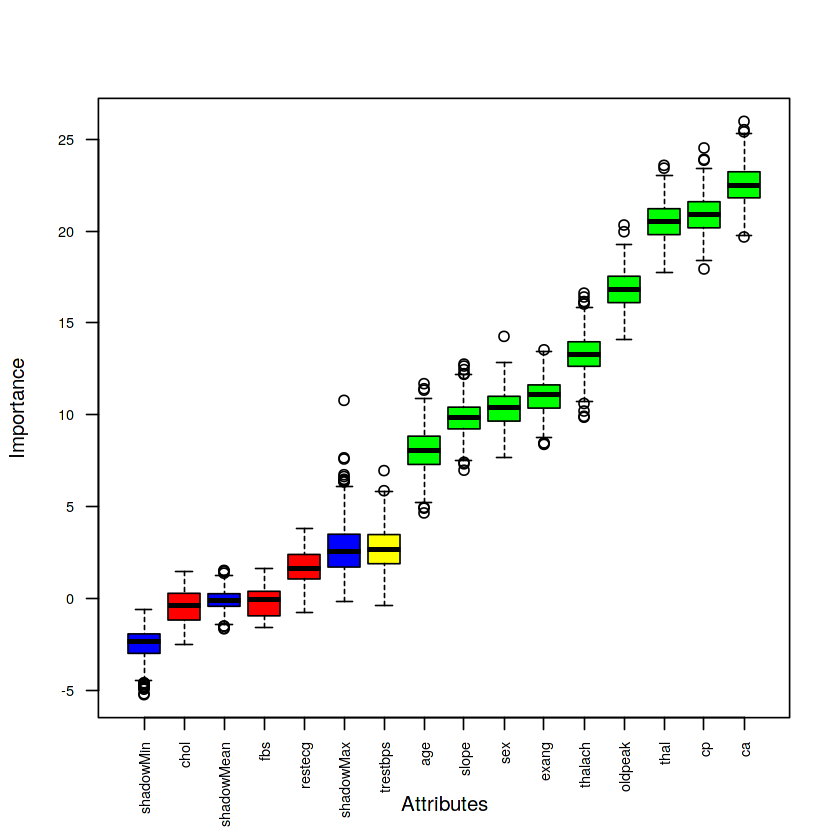

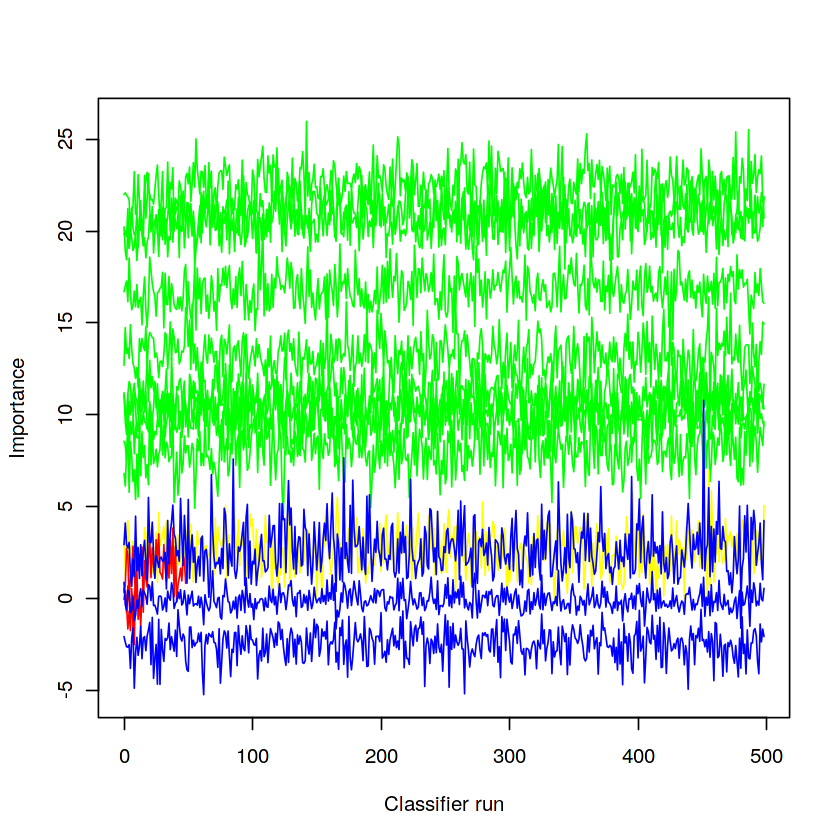

In [45]:
plot(boruta,las=2, cex.axis=0.7)
plotImpHistory(boruta)

In [0]:
#Tentative fix
bor<-TentativeRoughFix(boruta)
print(bor)
attStats(boruta)
getNonRejectedFormula(boruta)
getConfirmedFormula(boruta)

In [0]:
# New dataframe with the relevant features
heart <-subset(heart, select=getSelectedAttributes(boruta))
heart$target <- heartForLatterUse$target

#### Dummies for categorical data

https://www.kaggle.com/cdabakoglu/heart-disease-classifications-machine-learning/
<br>
In this technique, the categorical variables **cp, slope, thal** are represented by a binary vector. The other categorical variables **sex, fbs, exang** remain the same because their categories are just 0 and 1

In [0]:
options(warnings=-1) #Hide warnings

result1 <- cbind(heart,dummy(heart$cp,sep="cp"))
result2 <- cbind(result1,dummy(heart$slope,sep="slope"))
heartlabel <- cbind(result2,dummy(heart$thal,sep="thal"))


#### To solve multicollinearity, the original categorical variables cp, slope, thal and the first component of the dummies' vectors are revomed
drop <-c("cp","slope","thal","NAcp0","NAslope0","NAthal1")
heartlabel <-heartlabel[,!(names(heartlabel) %in% drop)]
head(heartlabel)
dim(heartlabel)

In [0]:
str(heartlabel)

#### Splitting Data

In [0]:
set.seed(123)

#Split the data 70% for training and 30% for test
ind <- sample(2,nrow(heartlabel),replace=TRUE,prob=c(0.7,0.3))
heart_train <- heartlabel[ind==1,]
heart_test <- heartlabel[ind==2,]

cat("Dimension of the train dataset: ", dim(heart_train)[1], "x", dim(heart_train)[2])

cat(", Dimension of the test dataset: ", dim(heart_test)[1], "x", dim(heart_test)[2])

#### Data normalization

Some algorithms in machine learning are more sensitive to the scale of data than others since the distance between the data points is very important.

In order to avoid this problem, a common scale (between 0 and 1) is often used which keeps the distributions of variables the same. This is often referred to as min-max scaling. The formula is shown below
$$z_{i}= \frac{x_{i}-min(x)}{max(x)-min(x)}$$

With $z_{i}$ as the new entry for each $x_{i}$ in the feature analyzed

In [0]:
#Function to normalize
#Parameters: xRef= vector/matrix of reference to normalize, xNorm= vector/matrix to normalize based on xRef
normalize <- function(xRef,xNorm) {
            return ((xNorm - min(xRef)) / (max(xRef) - min(xRef)))
            }

In [0]:
# New dataframes with features normalized
heartTrainNorm <- as.data.frame(mapply(normalize, heart_train,heart_train))

heartTestNorm <- as.data.frame(mapply(normalize, heart_train,heart_test))

#### PCA

##### FIRST ATTEMP WITH PRE-PROCESSED VARIABLES (DUMMY+NORMALIZATION)

In [0]:
# dataframe for train without the target
heartNoTarget <- heartTrainNorm[ , -which(names(heartTrainNorm) %in% c("target"))]

In [0]:
# Find the PCA
heartTrainNormPCA <-prcomp(x = heartNoTarget, scale = FALSE, center = TRUE)

In [0]:
summary(heartTrainNormPCA)

In [0]:
biplot(heartTrainNormPCA, col = c("grey", "steelblue"))

It presents a more even distribution of the loading vectors (because of the scaling)

In [0]:
#Getting proportion of variance
heartTrainNormPCAvar <-heartTrainNormPCA$sdev^2
pve <- heartTrainNormPCAvar/sum(heartTrainNormPCAvar) #Proportion of variance of principal components

par(mfrow=c(1,2))
#Plot variance explained for each principal component
plot(pve, xlab = "Principal Component", ylab ="Proportion of Variance Explained", ylim = c(0,1), type ="b")
# Plot cumulative proportion of variance explained
plot(cumsum(pve), xlab = "Principal Component",
     ylab = "Cumulative Proportion of Variance Explained",
     ylim = c(0, 1), type = "b")
abline(h=0.8)

**Conclusion:** Select the first four components

In [0]:
# Scatter plot observations by components 1 and 2
target <- as.numeric(heartTrainNorm$target == 1)
par(mfrow=c(1,2))
plot(heartTrainNormPCA$x[, c(1, 2)], col = (target + 1), 
     xlab = "PC1", ylab = "PC2")

# Repeat for components 1 and 3
plot(heartTrainNormPCA$x[, c(1, 3)], col = (target + 1), 
     xlab = "PC1", ylab = "PC3")

In [0]:
#Histograms of the first two components
par(mfrow=c(1,2))
hist(heartTrainNormPCA$x[, 1], main="Histogram for PC1",xlab="PC1")
hist(heartTrainNormPCA$x[, 2], main="Histogram for PC2",xlab="PC2")

##### SECOND ATTEMP WITH ORIGINAL VARIABLES

In [0]:
#Split data. HELP!! USE THE ENTIRE DATASET OR THE SPLITTED ONE
indOriginal <- sample(2,nrow(heartForLatterUse),replace=TRUE,prob=c(0.7,0.3))
heartOriginal_train <- heartForLatterUse[indOriginal==1,]
heartOriginal_test <- heartForLatterUse[indOriginal==2,]
#PCA with original features
heartOriginalPCA <-prcomp(x = subset(heartOriginal_train,select = -target), scale = FALSE, center = TRUE)
summary(heartOriginalPCA)

In [0]:
biplot(heartOriginalPCA, col = c("grey", "steelblue"), cex= c(0.5, 1.3))

In [0]:
#Getting proportion of variance
heartOriginalPCAvar <-heartOriginalPCA$sdev^2
pve <- heartOriginalPCAvar/sum(heartOriginalPCAvar) #Proportion of variance of principal components

par(mfrow=c(1,2))
#Plot variance explained for each principal component
plot(pve, xlab = "Principal Component", ylab ="Proportion of Variance Explained", ylim = c(0,1), type ="b")
# Plot cumulative proportion of variance explained
plot(cumsum(pve), xlab = "Principal Component",
     ylab = "Cumulative Proportion of Variance Explained",
     ylim = c(0, 1), type = "b")
abline(h=0.8)

**Conclusion:** Select the first component

In [0]:
# Scatter plot observations by components 1 and 2
target <- as.numeric(heartOriginal_train$target == 1)
par(mfrow=c(1,2))
plot(heartOriginalPCA$x[, c(1, 2)], col = (target + 1), 
     xlab = "PC1", ylab = "PC2")

# Scatter plot observations by components 1 and 3
plot(heartOriginalPCA$x[, c(1, 3)], col = (target + 1), 
     xlab = "PC1", ylab = "PC3")

In [0]:
par(mfrow=c(1,2))
hist(heartOriginalPCA$x[, 1], main="Histogram for PC1",xlab="PC1")
hist(heartOriginalPCA$x[, 2], main="Histogram for PC2",xlab="PC2")

#### COMPARISON BETWEEN BOTH PCA ATTEMPS

In [0]:
par(mfrow=c(1,2))
screeplot(heartTrainNormPCA, type ="lines", main="Preprocessed data")
screeplot(heartOriginalPCA, type ="lines", main="Original data")

**Conclusion:** It seems as is better to keep the original variables and select the first principal component. **BUT WHY?**

For extracting the values of PCA and use them in the models:
https://www.analyticsvidhya.com/blog/2016/03/pca-practical-guide-principal-component-analysis-python/

#### Linear Discriminant Analysis (LDA)

##### ATTEMP1 USE THE OUTPUT FROM PCA WITH THE FIRST TWO COMPONENTS (ATTEMP1 WITH PREPROCESSED DATA)

In [0]:
# HELP!! TO PERFORM THE LDA IS NECESSARY TO CREATE A NEW DATAFRAME ADDING THE TARGET COLUMN. IS THIS WAY OK?
heartPCAtarget <-as.data.frame(heartTrainNormPCA$x[,c(1,2)])
heartPCAtarget$target <-heartTrainNorm$target

In [0]:
linear <- lda(target~.,data=heartPCAtarget)
linear
p <- predict(linear,heartPCAtarget)
p

In [0]:
ldahist(data = p$x[, 1], g= heartPCAtarget$target)

In [0]:
#Confusion Matrix testing testing data
p1<- predict(linear, heartPCAtarget)$class
tab <- table(Predicted=p1, Actual=heartPCAtarget$target)
tab
(AccuracyTrainLDA1 <- sum(diag(tab))/sum(tab))


#transform test into PCA
heartPCAtargetTest <- predict(heartTrainNormPCA, newdata = heartTestNorm)
heartPCAtargetTest <- as.data.frame(heartPCAtargetTest)[,c(1,2)]
p2<- predict(linear,heartPCAtargetTest)$class
#Confusion Matrix testing training data
tab2 <- table(Predicted=p2, Actual=heartTestNorm$target)
tab2
(AccuracyTestLDA1 <- sum(diag(tab2))/sum(tab2))

29 miss classifications in the model with training data and 15 with testing data, Accuracy of the model: 86.57% with training data and 80% with testing data

Conclusion: LDA do not help us to have a clear separation between the two groups as it can be seen in the past histogram, both variables were not maximally separated. LDA only makes sense in a multiclass setting.

##### ATTEMP2 USE THE OUTPUT FROM PCA WITH THE FIRST TWO COMPONENTS (ATTEMP2 WITH ORIGINAL DATA)

In [0]:
heartOriginalPCAtarget <-as.data.frame(heartOriginalPCA$x[,c(1,2)])
heartOriginalPCAtarget$target <-heartOriginal_train$target

In [0]:
linear <- lda(target~.,heartOriginalPCAtarget)
linear
p <- predict(linear,heartOriginalPCAtarget)
p

In [0]:
ldahist(data = p$x[, 1], g= heartOriginalPCAtarget$target)

In [0]:
#Confusion Matrix testing data
p1<- predict(linear, heartOriginalPCAtarget)$class
tab <- table(Predicted=p1, Actual=heartOriginalPCAtarget$target)
tab
(AccuracyTrainLDA2 <- sum(diag(tab))/sum(tab))

#transform test into PCA
heartOriginalPCAtargetTest <- predict(heartOriginalPCA, newdata = heartOriginal_test)
heartOriginalPCAtargetTest <- as.data.frame(heartOriginalPCAtargetTest)
p2<- predict(linear,heartOriginalPCAtargetTest)$class
#Confusion Matrix testing training data
tab2 <- table(Predicted=p2, Actual=heartOriginal_test$target)
tab2
(AccuracyTestLDA2 <- sum(diag(tab2))/sum(tab2))

##### ATTEMP3 USE THE ORIGINAL DATA

In [0]:
linear <- lda(target~.,heartOriginal_train)
linear
p <- predict(linear,heartOriginal_train)
p

In [0]:
ldahist(data = p$x[, 1], g= heartOriginal_train$target)

In [0]:
#Confusion Matrix testing data
p1<- predict(linear, heartOriginal_train)$class
tab <- table(Predicted=p1, Actual=heartOriginal_train$target)
tab
(AccuracyTrainLDA3 <- sum(diag(tab))/sum(tab))

#Confusion Matrix testing training data
p2<- predict(linear,heartOriginal_test)$class
tab2 <- table(Predicted=p2, Actual=heartOriginal_test$target)
tab2
(AccuracyTestLDA3 <- sum(diag(tab2))/sum(tab2))

##### COMPARISON BETWEEN THE THREE ATTEMPTS FOR LDA

In [0]:
LDA1<-c(AccuracyTrainLDA1,AccuracyTestLDA1)
LDA2<-c(AccuracyTrainLDA2,AccuracyTestLDA2)
LDA3<-c(AccuracyTrainLDA3,AccuracyTestLDA3)

comparison<-data.frame(LDA1,LDA2,LDA3)
row.names(comparison)<-c("Test","Train")
comparison

**Conclusion:** HELP!! No idea how to continue with the results of LDA

### Modeling <a class="anchor" id="mo"></a>

The following model is based on the output from PCA (attemp1 with processed data)

#### k-Nearest Neighbors (KNN)

In [0]:
library(class)
# knn(training, test, target_training)
heart_pred <-knn(subset(heartPCAtarget,select = -target),heartPCAtargetTest,heartPCAtarget$target)

In [0]:
# Create a confusion matrix of the predicted versus actual values
heart_actual <- heartTestNorm$target
table(heart_pred, heart_actual)

# Compute the accuracy
mean(heart_pred == heart_actual)